# BQL Examples

In [26]:
# Imports
import altair as alt

from polars_bloomberg import BQuery

alt.renderers.enable("svg")

RendererRegistry.enable('svg')

In [2]:
# Basic example with signle data point
with BQuery() as bq:
    df_lst = bq.bql("get(px_last) for(['IBM US Equity', 'OMX Index'])")
df_lst[0]

ID,px_last,DATE,CURRENCY
str,f64,date,str
"""IBM US Equity""",229.33,2024-12-17,"""USD"""
"""OMX Index""",2544.604,2024-12-17,"""SEK"""


In [3]:
# Average PE ratio per sector
query = """
let(#avg_pe=avg(group(pe_ratio(), gics_sector_name()));)
get(#avg_pe)
for(members('SPX Index'))
"""
with BQuery() as bq:
    df_lst = bq.bql(query)
df_lst[0].head()

ID,#avg_pe,REVISION_DATE,AS_OF_DATE,PERIOD_END_DATE,ORIG_IDS,GICS_SECTOR_NAME()
str,f64,date,date,date,str,str
"""Communication Services""",26.324383,2024-11-14,2024-12-17,2024-09-30,null,"""Communication Services"""
"""Consumer Discretionary""",26.605797,2024-12-11,2024-12-17,2024-11-23,null,"""Consumer Discretionary"""
"""Consumer Staples""",19.362589,2024-12-13,2024-12-17,2024-11-24,null,"""Consumer Staples"""
"""Energy""",18.155505,2024-11-12,2024-12-17,2024-09-30,null,"""Energy"""
"""Financials""",37.120773,2024-11-26,2024-12-17,2024-09-30,null,"""Financials"""


In [4]:
# Duration and ZSpread for search results
query = """
let(#dur=duration(duration_type=MODIFIED);
    #zsprd=spread(spread_type=Z);)
get(name(), #dur, #zsprd)
for(filter(screenresults(type=SRCH, screen_name='@COCO'),
           ticker in ['SEB', 'SHBASS']))
"""

with BQuery() as bq:
    df_lst = bq.bql(query)
df_lst.combine()

ID,name(),#dur,DATE,#zsprd
str,str,f64,date,f64
"""BW924993 Corp""","""SEB 6 ⅞ PERP""",2.224876,2024-12-17,219.962108
"""YU819930 Corp""","""SEB 6 ¾ PERP""",5.366166,2024-12-17,309.154337
"""ZO703315 Corp""","""SHBASS 4 ⅜ PERP""",1.950612,2024-12-17,214.664365
"""ZO703956 Corp""","""SHBASS 4 ¾ PERP""",4.939148,2024-12-17,256.163102
"""ZQ349286 Corp""","""SEB 5 ⅛ PERP""",0.389946,2024-12-17,200.569138
"""YV402592 Corp""","""SEB Float PERP""",0.206908,2024-12-17,235.23


In [8]:
# Average OAS spread for Nvidia bonds per maturity bucket
query = """
let(
    #bins = bins(maturity_years,
                 [3,9,18,30],
                 ['(1) 0-3','(2) 3-9','(3) 9-18','(4) 18-30','(5) 30+']);
    #average_spread = avg(group(spread(st=oas),#bins));
)
get(#average_spread)
for(filter(bonds('NVDA US Equity', issuedby = 'ENTITY'),
           maturity_years != NA))
"""

with BQuery() as bq:
    df_lst = bq.bql(query)
df_lst[0]

ID,#average_spread,DATE,ORIG_IDS,#BINS
str,f64,date,str,str
"""(1) 0-3""",29.476654,2024-12-17,"""QZ552396 Corp""","""(1) 0-3"""
"""(2) 3-9""",58.500884,2024-12-17,null,"""(2) 3-9"""
"""(3) 9-18""",107.83985,2024-12-17,"""BH393780 Corp""","""(3) 9-18"""
"""(4) 18-30""",133.525275,2024-12-17,"""BH393781 Corp""","""(4) 18-30"""
"""(5) 30+""",149.245693,2024-12-17,"""BH393782 Corp""","""(5) 30+"""


In [9]:
# stocks with 20d EMA above 200d EMA and RSI > 53
with BQuery() as bq:
    df_lst = bq.bql(
        """
        let(#ema20=emavg(period=20);
            #ema200=emavg(period=200);
            #rsi=rsi(close=px_last());)
        get(name(), #ema20, #ema200, #rsi)
        for(filter(members('OMX Index'),
                    and(#ema20 > #ema200, #rsi > 53)))
        with(fill=PREV)
        """
    )
df_lst.combine()

ID,name(),#ema20,DATE,CURRENCY,#ema200,#rsi
str,str,f64,date,str,f64,f64
"""ERICB SS Equity""","""Telefonaktiebolaget LM Ericsso""",90.152605,2024-12-17,"""SEK""",75.073609,56.010064
"""ABB SS Equity""","""ABB Ltd""",630.622467,2024-12-17,"""SEK""",566.585769,53.763079
"""SEBA SS Equity""","""Skandinaviska Enskilda Banken""",153.80595,2024-12-17,"""SEK""",150.750809,56.460733
"""ASSAB SS Equity""","""Assa Abloy AB""",339.017593,2024-12-17,"""SEK""",317.074403,53.351646


In [13]:
# Axes for Swedish AT1 bonds with bids
query = """
let(#ax=axes();)
get(name, #ax)
for(filter(bondsuniv(ACTIVE),
    crncy()=='USD' and
    basel_iii_designation() == 'Additional Tier 1' and
    country_iso() == 'SE' and
    is_axed('Bid') == True))
with(aggregateby=SECURITY)
"""

with BQuery() as bq:
    df_lst = bq.bql(query)
df_lst.combine()

ID,name,#ax,ASK_DEPTH,BID_DEPTH,ASK_TOTAL_SIZE,BID_TOTAL_SIZE
str,str,str,i64,i64,f64,f64
"""ZO703315 Corp""","""SHBASS 4 ⅜ PERP""","""Y""",null,1,null,5e6
"""ZL122341 Corp""","""SWEDA 7 ⅝ PERP""","""Y""",null,1,null,1.4e6
"""ZQ349286 Corp""","""SEB 5 ⅛ PERP""","""Y""",1,3,5e6,2.02e7
"""ZO703956 Corp""","""SHBASS 4 ¾ PERP""","""Y""",2,2,3.2e6,6e6
"""BW924993 Corp""","""SEB 6 ⅞ PERP""","""Y""",1,1,5e6,5e6


In [25]:
# Get Bond Universe from Equity Ticker
query = """
let(#rank=normalized_payment_rank();
    #oas=spread(st=oas);
    #nxt_call=nxt_call_dt();
    )
get(name(), #rank, #nxt_call, #oas)
for(filter(bonds('GTN US Equity'), series() == '144A'))
"""

with BQuery() as bq:
    results = bq.bql(query)
    df = results.combine()
    print(df)

shape: (5, 6)
┌───────────────┬───────────────────┬──────────────────┬────────────┬────────────┬────────────┐
│ ID            ┆ name()            ┆ #rank            ┆ #nxt_call  ┆ #oas       ┆ DATE       │
│ ---           ┆ ---               ┆ ---              ┆ ---        ┆ ---        ┆ ---        │
│ str           ┆ str               ┆ str              ┆ date       ┆ f64        ┆ date       │
╞═══════════════╪═══════════════════╪══════════════════╪════════════╪════════════╪════════════╡
│ YX231113 Corp ┆ GTN 10 ½ 07/15/29 ┆ 1st Lien Secured ┆ 2026-07-15 ┆ 598.66491  ┆ 2024-12-17 │
│ BS116983 Corp ┆ GTN 5 ⅜ 11/15/31  ┆ Sr Unsecured     ┆ 2026-11-15 ┆ 1193.17529 ┆ 2024-12-17 │
│ AV438089 Corp ┆ GTN 7 05/15/27    ┆ Sr Unsecured     ┆ 2024-12-24 ┆ 400.340456 ┆ 2024-12-17 │
│ ZO860846 Corp ┆ GTN 4 ¾ 10/15/30  ┆ Sr Unsecured     ┆ 2025-10-15 ┆ 1249.34346 ┆ 2024-12-17 │
│ LW375188 Corp ┆ GTN 5 ⅞ 07/15/26  ┆ Sr Unsecured     ┆ 2025-01-13 ┆ 173.761744 ┆ 2024-12-17 │
└───────────────┴─────────

In [27]:
# Total Return of GTN Bonds
query = """
let(#rng = range(-1M, 0D);
    #rets = return_series(calc_interval=#rng,per=W);)
get(#rets)
for(filter(bonds('GTN US Equity'), series() == '144A'))
"""

with BQuery() as bq:
    results = bq.bql(query)
    df = results[0].pivot(on="ID", index="DATE", values="#rets")
    print(df)

shape: (6, 6)
┌────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┐
│ DATE       ┆ YX231113 Corp ┆ BS116983 Corp ┆ AV438089 Corp ┆ ZO860846 Corp ┆ LW375188 Corp │
│ ---        ┆ ---           ┆ ---           ┆ ---           ┆ ---           ┆ ---           │
│ date       ┆ f64           ┆ f64           ┆ f64           ┆ f64           ┆ f64           │
╞════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ 2024-11-17 ┆ null          ┆ null          ┆ null          ┆ null          ┆ null          │
│ 2024-11-24 ┆ 0.001653      ┆ 0.051179      ┆ 0.020363      ┆ 0.001371      ┆ -0.002939     │
│ 2024-12-01 ┆ 0.002837      ┆ 0.010405      ┆ -0.001466     ┆ 0.007275      ┆ 0.000581      │
│ 2024-12-08 ┆ -0.000041     ┆ 0.016145      ┆ 0.000766      ┆ 0.024984      ┆ 0.000936      │
│ 2024-12-15 ┆ 0.001495      ┆ -0.047        ┆ -0.000233     ┆ -0.043509     ┆ 0.002241      │
│ 2024-12-17 ┆ 0.00008       ┆ -0.00

In [ ]:
# RT1 Axes with all columns
query = """
let(#ax=axes();)
get(name, #ax, amt_outstanding)
for(filter(bondsuniv(ACTIVE),
    crncy() in ['USD', 'EUR'] and
    solvency_ii_designation() == 'Restricted Tier 1' and
    amt_outstanding() > 7.5e8 and
    is_axed('Bid') == True))
preferences(addcols=all)
"""

with BQuery() as bq:
    results = bq.bql(query)
results.combine()

ID,name,#ax,ASK_PRICE,BID_PRICE,ASK_DEPTH,BID_DEPTH,ASK_DEALER,BID_DEALER,ASK_SIZE,BID_SIZE,ASK_TOTAL_SIZE,BID_TOTAL_SIZE,ASK_PRICE_IS_DERIVED,BID_PRICE_IS_DERIVED,ASK_SPREAD,BID_SPREAD,ASK_SPREAD_IS_DERIVED,BID_SPREAD_IS_DERIVED,ASK_YIELD,BID_YIELD,ASK_YIELD_IS_DERIVED,BID_YIELD_IS_DERIVED,ASK_AXE_SOURCE,BID_AXE_SOURCE,ASK_BROKER,BID_BROKER,ASK_HIST_AGG_SIZE,BID_HIST_AGG_SIZE,amt_outstanding,CURRENCY_OF_ISSUE,MULTIPLIER,CURRENCY
str,str,str,f64,f64,i64,i64,str,str,f64,f64,f64,f64,bool,bool,f64,f64,bool,bool,f64,f64,bool,bool,str,str,str,str,f64,f64,f64,str,f64,str
"""BM368057 Corp""","""ALVGR 2 ⅝ PERP""","""Y""",88.034,87.427,5,1,"""BARC""","""IMI""",1.2e6,1e6,7.2e6,1e6,null,null,287.031,300.046,true,true,4.854,4.976,true,true,"""ERUN""","""ERUN""","""BXOL""","""IMIC""",6.68e6,8.92e6,1.2500e9,"""EUR""",1.0,"""EUR"""
"""EK588238 Corp""","""ASSGEN 4.596 PERP""","""Y""",101.0,100.13,4,6,"""MSAX""","""A2A""",500000.0,100000.0,1.556e7,3.83e7,null,null,108.9,207.889,true,true,3.466,4.434,null,true,"""ERUN""","""BBX""","""MSAX""","""A2A""",1.70424e7,3.17e7,1.0004e9,"""EUR""",1.0,"""EUR"""
"""BR244025 Corp""","""ALVGR 3.2 PERP""","""Y""",88.0,86.875,3,4,"""UBS""","""DB""",5e6,1e6,1.1e7,1.4e7,null,null,49.33,414.602,true,true,7.34258,8.553,null,true,"""ERUN""","""ERUN""","""UBSW""","""DABC""",1.6876e6,3.6e7,1.2500e9,"""USD""",1.0,"""USD"""


In [23]:
# revenue per segment
query = """
    let(#segment=segment_name();
        #revenue=sales_Rev_turn(fpt=q, fpr=range(2023Q3, 2024Q3));
        )
    get(#segment, #revenue)
    for(segments('GTN US Equity',type=reported,hierarchy=PRODUCT, level=1))
"""
with BQuery() as bq:
    results = bq.bql(query)
    df = results.combine().pivot(
        index="PERIOD_END_DATE", on="#segment", values="#revenue"
    )
    print(df)

shape: (5, 5)
┌─────────────────┬──────────────┬──────────────────────┬────────┬────────────┐
│ PERIOD_END_DATE ┆ Broadcasting ┆ Production Companies ┆ Other  ┆ Adjustment │
│ ---             ┆ ---          ┆ ---                  ┆ ---    ┆ ---        │
│ date            ┆ f64          ┆ f64                  ┆ f64    ┆ f64        │
╞═════════════════╪══════════════╪══════════════════════╪════════╪════════════╡
│ 2023-09-30      ┆ 7.83e8       ┆ 2e7                  ┆ 1.6e7  ┆ null       │
│ 2023-12-31      ┆ 8.13e8       ┆ 3.2e7                ┆ 1.9e7  ┆ null       │
│ 2024-03-31      ┆ 7.8e8        ┆ 2.4e7                ┆ 1.9e7  ┆ null       │
│ 2024-06-30      ┆ 8.08e8       ┆ 1.8e7                ┆ 0.0    ┆ null       │
│ 2024-09-30      ┆ 9.24e8       ┆ 2.6e7                ┆ 1.7e7  ┆ null       │
└─────────────────┴──────────────┴──────────────────────┴────────┴────────────┘


shape: (5, 11)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ maturity ┆ Basic     ┆ Consumer, ┆ Energy    ┆ … ┆ Financial ┆ Technolog ┆ Utilities ┆ Diversifi │
│ ---      ┆ Materials ┆ Non-cycli ┆ ---       ┆   ┆ ---       ┆ y         ┆ ---       ┆ ed        │
│ i64      ┆ ---       ┆ cal       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ f64       ┆ ---       │
│          ┆ f64       ┆ ---       ┆           ┆   ┆           ┆ f64       ┆           ┆ f64       │
│          ┆           ┆ f64       ┆           ┆   ┆           ┆           ┆           ┆           │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2025     ┆ 1.5e8     ┆ 5.34916e8 ┆ 5e8       ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2026     ┆ 4.4013e9  ┆ 9.3293e9  ┆ 8.2931e9  ┆ … ┆ 1.3524e10 ┆ 4.0608e9  ┆ 2.5202e9  ┆ null      │
│ 2027     ┆ 8.3921e9  ┆ 2.3409e10 ┆ 1.2427e10 ┆ … ┆ 1.9430e10 ┆ 4.3367e9  ┆

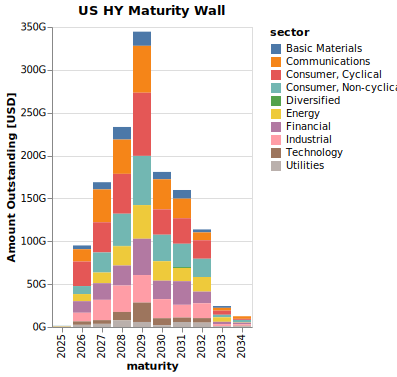

In [38]:
# Maturity Wall for US HY bonds
query = """
let(#mv=sum(group(amt_outstanding(currency=USD),
                  by=[year(maturity()), industry_sector()]));)
get(#mv)
for(members('LF98TRUU Index'))
"""
with BQuery() as bq:
    results = bq.bql(query)
df = results.combine().rename(
    {"YEAR(MATURITY())": "maturity", "INDUSTRY_SECTOR()": "sector", "#mv": "mv"}
)

print(df.pivot(index="maturity", on="sector", values="mv").head())

alt.Chart(df.drop_nulls(subset=["maturity"]), title="US HY Maturity Wall").mark_bar().encode(
    x=alt.X("maturity:O"),
    y=alt.Y("mv:Q").axis(format="~s").title("Amount Outstanding [USD]"),
    color=alt.Color("sector:N"),
).transform_filter(alt.datum.maturity < 2035)  # noqa: PLR2004

shape: (5, 11)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ maturity ┆ Consumer, ┆ Consumer, ┆ Financial ┆ … ┆ Energy    ┆ Technolog ┆ Utilities ┆ Diversifi │
│ ---      ┆ Cyclical  ┆ Non-cycli ┆ ---       ┆   ┆ ---       ┆ y         ┆ ---       ┆ ed        │
│ i64      ┆ ---       ┆ cal       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ f64       ┆ ---       │
│          ┆ f64       ┆ ---       ┆           ┆   ┆           ┆ f64       ┆           ┆ f64       │
│          ┆           ┆ f64       ┆           ┆   ┆           ┆           ┆           ┆           │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2025     ┆ 2e8       ┆ 1.2989e8  ┆ 3e8       ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2026     ┆ 1.6235e10 ┆ 1.0756e10 ┆ 7.8707e9  ┆ … ┆ 6.21491e8 ┆ 2.7272925 ┆ 1.6850e9  ┆ null      │
│          ┆           ┆           ┆           ┆   ┆           ┆ e8        ┆

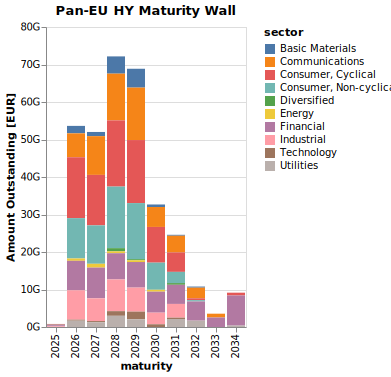

In [31]:
# Maturity Wall for EU HY bonds
query = """
let(#mv=sum(group(amt_outstanding(currency=EUR),
                  by=[year(maturity()), industry_sector()]));)
get(#mv)
for(members('LP01TREU Index'))
"""
with BQuery() as bq:
    results = bq.bql(query)
df = results.combine().rename(
    {"YEAR(MATURITY())": "maturity", "INDUSTRY_SECTOR()": "sector", "#mv": "mv"}
)

print(df.pivot(index="maturity", on="sector", values="mv").head())

alt.Chart(df.drop_nulls(subset=["maturity"]), title="Pan-EU HY Maturity Wall").mark_bar().encode(
    x=alt.X("maturity:O"),
    y=alt.Y("mv:Q").axis(format="~s").title("Amount Outstanding [EUR]"),
    color=alt.Color("sector:N"),
).transform_filter(alt.datum.maturity < 2035)  # noqa: PLR2004